In [1]:
!pip install replay-rec --quiet
!pip install rs_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rs_datasets import MovieLens
from datetime import datetime

In [2]:
ml = MovieLens('1m')
data = ml.ratings
data["timestamp"] = data['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
data

,user_id,item_id,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
...,...,...,...,...
1000204,6040,1091,1,2000-04-26 02:35:41
1000205,6040,1094,5,2000-04-25 23:21:27
1000206,6040,562,5,2000-04-25 23:19:06
1000207,6040,1096,4,2000-04-26 02:20:48


### EDA

In [3]:
count_user_interaction = data.groupby('user_id')['item_id'].count()
count_item_interaction = data.groupby('item_id')['user_id'].count()

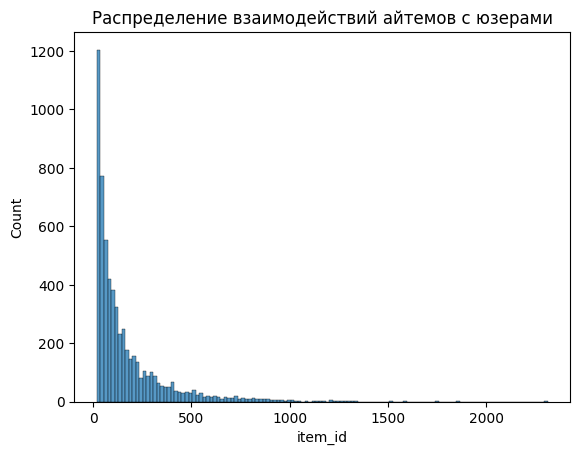

In [4]:
sns.histplot(count_user_interaction)
plt.title('Распределение взаимодействий айтемов с юзерами')
plt.show()

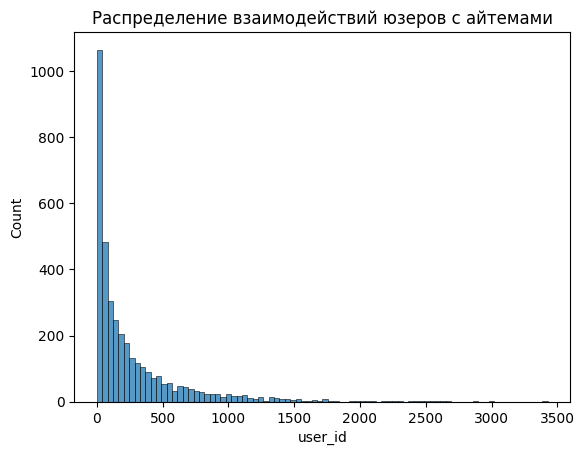

In [5]:
sns.histplot(count_item_interaction)
plt.title('Распределение взаимодействий юзеров с айтемами')
plt.show()

In [6]:
print(f'Уникальных юзеров: {data["user_id"]. nunique()}')
print(f'Уникальных фильмов: {data["item_id"].nunique()}')

Уникальных юзеров: 6040
Уникальных фильмов: 3706


In [7]:
stats = pd.Series()
stats['all_events'] = data.shape[0]
stats['all_user'] = data["user_id"].nunique()
stats['all_items'] = data["item_id"].nunique()
stats['mean_length'] = np.mean(data.groupby("user_id").count()["timestamp"])
stats['density'] = stats['all_events'] / (stats['all_items'] * stats['all_user'])
for key, value in zip(stats.keys(), stats.values):
    print(key, value)

<ipython-input-7-dda3c4d5477b>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


all_events 1000209.0
all_user 6040.0
all_items 3706.0
mean_length 165.5975165562914
density 0.044683625622312845


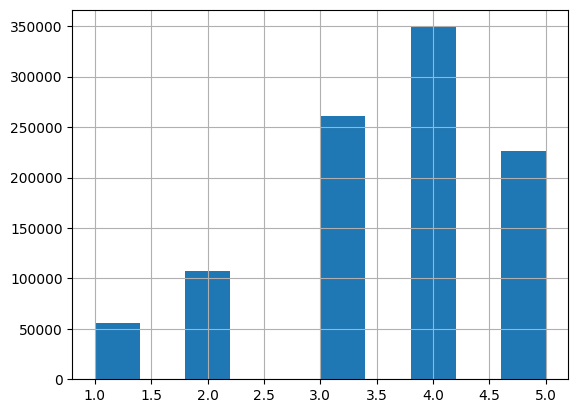

In [8]:
data['rating'].hist();

### Фильтрация данных

In [9]:
def drop_duplicates_items(data, user_id='user_id', item_id="item_id", timestamp="timestamp"):
    """Удаление повторяющихся айтемов в последовательности юзера вида i-i-j -> i-j."""

    data.sort_values([user_id, timestamp], inplace=True)
    data['user_item'] = data[user_id].astype(str) + '_' + data[item_id].astype(str)

    while (data['user_item'].shift() == data['user_item']).sum() != 0:
        not_duplicates_ind = data['user_item'].shift() != data['user_item']
        data = data.loc[not_duplicates_ind]

    data = data.drop('user_item', axis=1)

    return data

def filter_items(data, item_min_count, item_id="item_id"):
    """Фильтрация айтемов с малым количеством взаимодействий."""

    counts = data[item_id].value_counts()
    data = data[data[item_id].isin(counts[counts >= item_min_count].index)]

    return data

def filter_users(data, min_len, user_id='user_id'):
    """Фильтрация юзеров с малым количеством взаимодействий."""

    counts = data[user_id].value_counts()
    data = data[data[user_id].isin(counts[counts >= min_len].index)]

    return data

def FilterN(data, user_id='user_id', item_id='item_id', timestamp='timestamp', item_min_count=50, min_len=50):

    data = drop_duplicates_items(data, user_id, item_id, timestamp)
    data = filter_items(data, item_min_count, item_id)
    data = filter_users(data, min_len, user_id)

    return data

In [10]:
data = FilterN(data)

In [11]:
print('Количество взаимодействий = {}'.format(len(data)))
print('Количество юзеров = {}'.format(len(data.user_id.unique())))
print('Количество айтемов = {}'.format(len(data.item_id.unique())))

Количество взаимодействий = 920334
Количество юзеров = 4259
Количество айтемов = 2514


Релизация Replay

In [12]:
from replay.preprocessing.filters import NumInteractionsFilter
from replay.preprocessing.filters import LowRatingFilter
from replay.preprocessing.filters import MinCountFilter

In [13]:
ml = MovieLens('1m')
data = ml.ratings
data["timestamp"] = data['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
data

,user_id,item_id,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
...,...,...,...,...
1000204,6040,1091,1,2000-04-26 02:35:41
1000205,6040,1094,5,2000-04-25 23:21:27
1000206,6040,562,5,2000-04-25 23:19:06
1000207,6040,1096,4,2000-04-26 02:20:48


In [14]:
# Берем в каждой последовательности пользователя последние 128 айтемов
data = NumInteractionsFilter(num_interactions=164).transform(data)
# Оставляем последовательности с рейтингом три или выше
data = LowRatingFilter(value=3).transform(data)
# Убираем пользователей, у которых длина последовательности меньше 5
data = MinCountFilter(num_entries=5, groupby_column='user_id').transform(data)
# Убираем айтемы, у которых длина последовательности меньше 5
data = MinCountFilter(num_entries=5, groupby_column='item_id').transform(data)

In [15]:
print('Количество взаимодействий = {}'.format(len(data)))
print('Количество юзеров = {}'.format(len(data.user_id.unique())))
print('Количество айтемов = {}'.format(len(data.item_id.unique())))

Количество взаимодействий = 515600
Количество юзеров = 6038
Количество айтемов = 3060


### Разбиение данных

#### Случайное разбиение

In [16]:
data.sort_values(['user_id', 'timestamp'], inplace=True)

In [17]:
from replay.splitters.random_splitter import RandomSplitter
train, test = RandomSplitter(test_size=0.3, seed=32).split(data)

In [18]:
print('Количество взаимодействий в train= {}'.format(len(train)))
print('Количество юзеров в train = {}'.format(len(train.user_id.unique())))
print('Количество айтемов в train = {}'.format(len(train.item_id.unique())))

Количество взаимодействий в train= 360920
Количество юзеров в train = 6038
Количество айтемов в train = 3060


In [19]:
print('Количество взаимодействий в test= {}'.format(len(test)))
print('Количество юзеров в test = {}'.format(len(test.user_id.unique())))
print('Количество айтемов в test = {}'.format(len(test.item_id.unique())))

Количество взаимодействий в test= 154680
Количество юзеров в test = 6038
Количество айтемов в test = 3018


In [20]:
print('Взаимодействия пользователя до разбиения данных \n', data[data.user_id == 4349])

Взаимодействия пользователя до разбиения данных 
         user_id  item_id  rating           timestamp
727128     4349     3773       3 2000-08-02 10:34:26
727123     4349     2362       5 2000-08-02 10:35:57
727113     4349     1924       4 2000-08-02 10:36:47
727109     4349     2810       3 2000-08-02 10:40:02
727122     4349     2351       3 2000-08-02 10:41:02
727118     4349     1219       3 2000-08-02 10:49:35
727106     4349      904       3 2000-08-02 10:59:14


In [21]:
print('Взаимодействия пользователя в train \n', train[train.user_id == 4349])
print('\n Взаимодействия пользователя в test \n', test[test.user_id == 4349])

Взаимодействия пользователя в train 
         user_id  item_id  rating           timestamp
727128     4349     3773       3 2000-08-02 10:34:26
727106     4349      904       3 2000-08-02 10:59:14
727109     4349     2810       3 2000-08-02 10:40:02
727123     4349     2362       5 2000-08-02 10:35:57
727113     4349     1924       4 2000-08-02 10:36:47
727118     4349     1219       3 2000-08-02 10:49:35

 Взаимодействия пользователя в test 
         user_id  item_id  rating           timestamp
727122     4349     2351       3 2000-08-02 10:41:02


### Разбиение по времени.

In [22]:
from replay.splitters.time_splitter import TimeSplitter
train, test = TimeSplitter(time_threshold='2000-08-02 10:41:02').split(data)

In [23]:
print('Количество взаимодействий в train= {}'.format(len(train)))
print('Количество юзеров в train = {}'.format(len(train.user_id.unique())))
print('Количество айтемов в train = {}'.format(len(train.item_id.unique())))

Количество взаимодействий в train= 137909
Количество юзеров в train = 1690
Количество айтемов в train = 2913


In [24]:
print('Количество взаимодействий в test= {}'.format(len(test)))
print('Количество юзеров в test = {}'.format(len(test.user_id.unique())))
print('Количество айтемов в test = {}'.format(len(test.item_id.unique())))

Количество взаимодействий в test= 377691
Количество юзеров в test = 4594
Количество айтемов в test = 3060


In [25]:
print('Взаимодействия пользователя до разбиения данных \n', data[data.user_id == 4349])

Взаимодействия пользователя до разбиения данных 
         user_id  item_id  rating           timestamp
727128     4349     3773       3 2000-08-02 10:34:26
727123     4349     2362       5 2000-08-02 10:35:57
727113     4349     1924       4 2000-08-02 10:36:47
727109     4349     2810       3 2000-08-02 10:40:02
727122     4349     2351       3 2000-08-02 10:41:02
727118     4349     1219       3 2000-08-02 10:49:35
727106     4349      904       3 2000-08-02 10:59:14


In [26]:
print('Взаимодействия пользователя в train \n', train[train.user_id == 4349])
print('\n Взаимодействия пользователя в test \n', test[test.user_id == 4349])

Взаимодействия пользователя в train 
         user_id  item_id  rating           timestamp
727128     4349     3773       3 2000-08-02 10:34:26
727123     4349     2362       5 2000-08-02 10:35:57
727113     4349     1924       4 2000-08-02 10:36:47
727109     4349     2810       3 2000-08-02 10:40:02

 Взаимодействия пользователя в test 
         user_id  item_id  rating           timestamp
727122     4349     2351       3 2000-08-02 10:41:02
727118     4349     1219       3 2000-08-02 10:49:35
727106     4349      904       3 2000-08-02 10:59:14


#### Last N splitter

In [27]:
from replay.splitters.last_n_splitter import LastNSplitter
train, test = LastNSplitter(N=2, query_column='user_id',divide_column="user_id").split(data)

In [28]:
print('Количество взаимодействий в train= {}'.format(len(train)))
print('Количество юзеров в train = {}'.format(len(train.user_id.unique())))
print('Количество айтемов в train = {}'.format(len(train.item_id.unique())))

Количество взаимодействий в train= 503524
Количество юзеров в train = 6038
Количество айтемов в train = 3060


In [29]:
print('Количество взаимодействий в test= {}'.format(len(test)))
print('Количество юзеров в test = {}'.format(len(test.user_id.unique())))
print('Количество айтемов в test = {}'.format(len(test.item_id.unique())))

Количество взаимодействий в test= 12076
Количество юзеров в test = 6038
Количество айтемов в test = 2228


In [30]:
print('Взаимодействия пользователя до разбиения данных \n', data[data.user_id == 4349])

Взаимодействия пользователя до разбиения данных 
         user_id  item_id  rating           timestamp
727128     4349     3773       3 2000-08-02 10:34:26
727123     4349     2362       5 2000-08-02 10:35:57
727113     4349     1924       4 2000-08-02 10:36:47
727109     4349     2810       3 2000-08-02 10:40:02
727122     4349     2351       3 2000-08-02 10:41:02
727118     4349     1219       3 2000-08-02 10:49:35
727106     4349      904       3 2000-08-02 10:59:14


In [31]:
print('Взаимодействия пользователя в train \n', train[train.user_id == 4349])
print('\n Взаимодействия пользователя в test \n', test[test.user_id == 4349])

Взаимодействия пользователя в train 
         user_id  item_id  rating           timestamp
727128     4349     3773       3 2000-08-02 10:34:26
727123     4349     2362       5 2000-08-02 10:35:57
727113     4349     1924       4 2000-08-02 10:36:47
727109     4349     2810       3 2000-08-02 10:40:02
727122     4349     2351       3 2000-08-02 10:41:02

 Взаимодействия пользователя в test 
         user_id  item_id  rating           timestamp
727118     4349     1219       3 2000-08-02 10:49:35
727106     4349      904       3 2000-08-02 10:59:14
